## Getting Started

This notebook will show you how to built a complexe pipeline using aikit and how to crossvalidated it

In [3]:
from aikit.datasets.datasets import load_dataset, DatasetEnum
Xtrain, y_train, _ ,_ , _ = load_dataset(DatasetEnum.titanic)
Xtrain.head(10)

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home_dest
0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,NaN,175.0,"Dorchester, MA"
1,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.0000,C23 C25 C27,S,NaN,NaN,"Winnipeg, MB"
2,1,"Sagesser, Mlle. Emma",female,24.0,0,0,PC 17477,69.3000,B35,C,9,NaN,NaN
3,3,"Panula, Master. Urho Abraham",male,2.0,4,1,3101295,39.6875,NaN,S,NaN,NaN,NaN
4,1,"Maioni, Miss. Roberta",female,16.0,0,0,110152,86.5000,B79,S,8,NaN,NaN
5,3,"Waelens, Mr. Achille",male,22.0,0,0,345767,9.0000,NaN,S,NaN,NaN,"Antwerp, Belgium / Stanton, OH"
6,3,"Reed, Mr. James George",male,NaN,0,0,362316,7.2500,NaN,S,NaN,NaN,NaN
7,1,"Swift, Mrs. Frederick Joel (Margaret Welles Ba...",female,48.0,0,0,17466,25.9292,D17,S,8,NaN,"Brooklyn, NY"
8,1,"Smith, Mrs. Lucien Philip (Mary Eloise Hughes)",female,18.0,1,0,13695,60.0000,C31,S,6,NaN,"Huntington, WV"
9,1,"Rowe, Mr. Alfred G",male,33.0,0,0,113790,26.5500,NaN,S,NaN,109.0,London


In [4]:
y_train[0:10]

array([0, 0, 1, 0, 1, 0, 0, 1, 1, 0], dtype=int64)

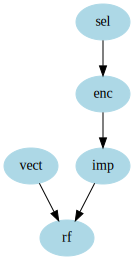

In [13]:
from aikit.pipeline import GraphPipeline
from aikit.transformers import ColumnsSelector, NumericalEncoder, NumImputer, CountVectorizerWrapper
from sklearn.ensemble import RandomForestClassifier

text_cols     = ["name","ticket"]
non_text_cols = [c for c in Xtrain.columns if c not in text_cols]

gpipeline = GraphPipeline(models = {
    "sel":ColumnsSelector(columns_to_use=non_text_cols),
    "enc":NumericalEncoder(columns_to_use="object"),
    "imp":NumImputer(),
    "vect":CountVectorizerWrapper(analyzer="word",columns_to_use=text_cols),
    "rf":RandomForestClassifier(n_estimators=100, random_state=123)
                       },
              edges = [("sel","enc","imp","rf"),("vect","rf")])

gpipeline.fit(Xtrain,y_train)
gpipeline.graphviz

In [17]:
from aikit.cross_validation import cross_validation
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(10, shuffle=True, random_state=123)

cv_res, yhat_proba = cross_validation(gpipeline, Xtrain, y_train,cv=cv, scoring=["accuracy", "roc_auc", "neg_log_loss"], return_predict=True, method="predict_proba")

cv_res

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


cv 0 started

cv 1 started

cv 2 started

cv 3 started

cv 4 started

cv 5 started

cv 6 started

cv 7 started

cv 8 started

cv 9 started



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   13.3s finished


,test_accuracy,test_roc_auc,test_neg_log_loss,train_accuracy,train_roc_auc,train_neg_log_loss,fit_time,score_time,n_test_samples,fold_nb
0,0.980952,0.998095,-0.116852,1.0,1.0,-0.043928,0.841272,0.133642,105,0
1,0.961905,0.969512,-0.484764,1.0,1.0,-0.042055,0.903584,0.126663,105,1
2,0.961905,0.994474,-0.139215,1.0,1.0,-0.041864,0.747745,0.117702,105,2
3,0.990476,1.000000,-0.102579,1.0,1.0,-0.042316,0.735497,0.120638,105,3
4,0.952381,0.994284,-0.130034,1.0,1.0,-0.044032,0.772531,0.119271,105,4
5,0.961905,0.996570,-0.134116,1.0,1.0,-0.041499,0.725558,0.126695,105,5
6,0.971429,0.998476,-0.140661,1.0,1.0,-0.047236,0.761099,0.116698,105,6
7,0.961905,0.995617,-0.155353,1.0,1.0,-0.040947,0.734543,0.111288,105,7
8,0.961538,0.994386,-0.132630,1.0,1.0,-0.041335,0.740471,0.111782,104,8
9,0.980769,0.996903,-0.150282,1.0,1.0,-0.044830,0.749113,0.112777,104,9


In [18]:
yhat_proba.head(10)

,0,1
0,1.00,0.00
1,0.88,0.12
2,0.05,0.95
3,0.93,0.07
4,0.07,0.93
5,1.00,0.00
6,1.00,0.00
7,0.03,0.97
8,0.06,0.94
9,0.98,0.02


### Using cross_validation you get in one call :
* both train and test score
* all the metrics
* the probabilities predicted for each observation